# Initializing

### Importing the librairies 

In [15]:
#Import relevant librairies

import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

#Set some settings for viewing and determine which package versions we are using
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.17.5 scipy==1.4.1 pandas==0.23.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.7.0


### Reading in the data to make an adata object

In [16]:
#Read in the AnnData from a 10X filtered matrix (use gene symbols for the variable names (variables-axis index). This line writes up an h5ad cache file which makes increses the reading speed for subsequent calls. We could also do this from a .h5ad file

adata = sc.read_10x_mtx('/Users/jm52/data/jm52_dummy/3kpbmc_scanpy/filtered_gene_bc_matrices/hg19',
    var_names='gene_symbols',                
    cache=True)   

#Making each of the var (gene) names unique. This is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`.
adata.var_names_make_unique()

#Let's look at the dimensions of our data
adata

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# Pre-processing

normalizing counts per cell
    finished (0:00:00)


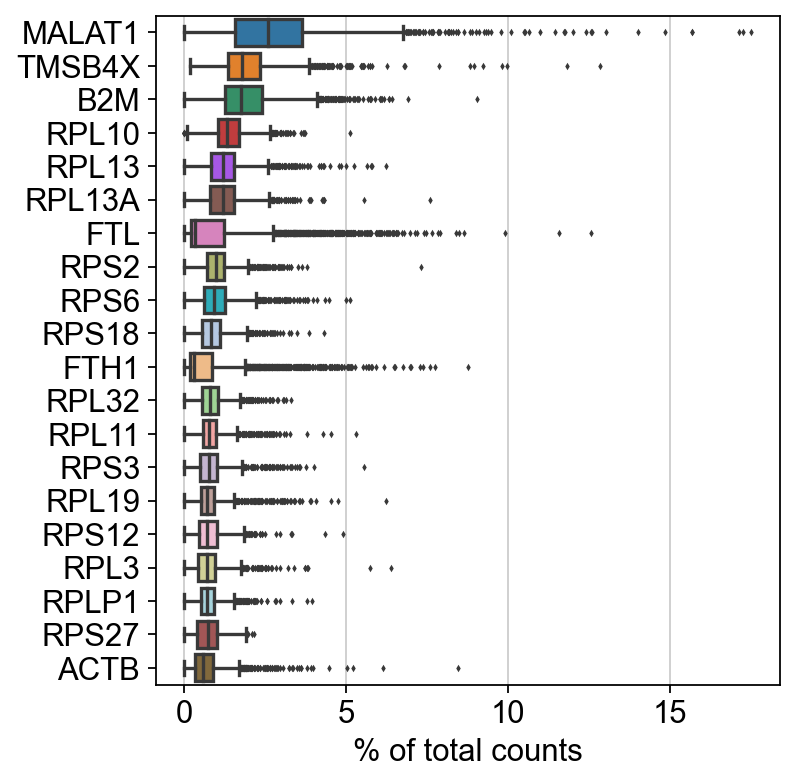

In [17]:
# Show the genes that have the highest fraction count/cell for all cells. This shows many housekeeping genes.
sc.pl.highest_expr_genes(adata, n_top=20, )

### Basic Filtering

In [18]:
#Filtering cells with less than 200 genes and genes present in less than 3 cells

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


### Computing the mitochondrial genes 

In [19]:
#Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  

#Compute the mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


### QC Plots & Filtering

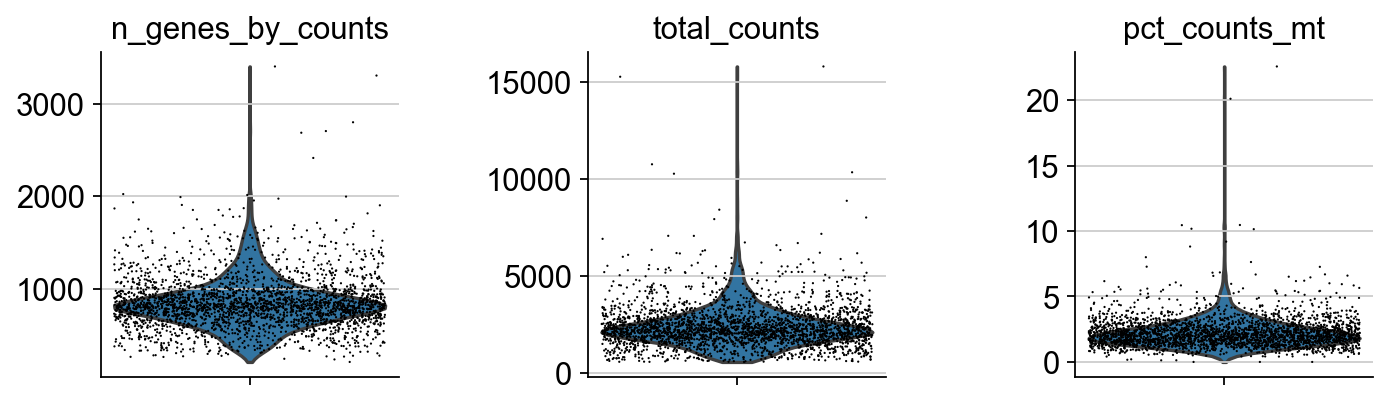

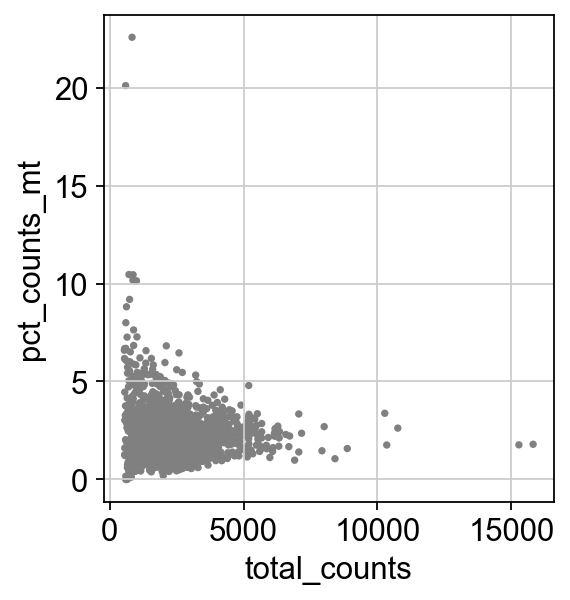

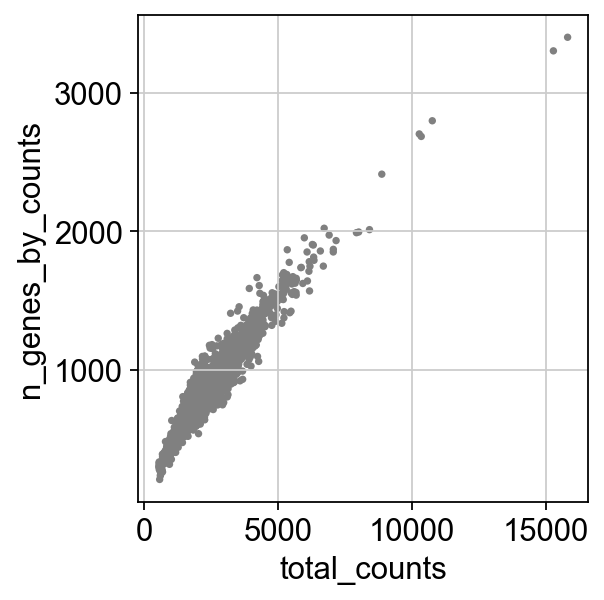

In [20]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Filtering out mitochondrial genes

In [21]:
# Filter out by slicing
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Look at the size of our object
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Normalizing

In [22]:
#Normalizing to 10 000 reads /cell
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/jm52/miniconda3/envs/sc_qc_cluster_j/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
print(adata.X.shape)
print(adata.X)

(2638, 13714)
  (0, 29)	4.1339397
  (0, 73)	4.1339397
  (0, 80)	8.2678795
  (0, 148)	4.1339397
  (0, 163)	4.1339397
  (0, 184)	4.1339397
  (0, 186)	4.1339397
  (0, 227)	169.49153
  (0, 229)	4.1339397
  (0, 230)	4.1339397
  (0, 231)	4.1339397
  (0, 247)	4.1339397
  (0, 266)	8.2678795
  (0, 268)	24.803638
  (0, 328)	4.1339397
  (0, 335)	4.1339397
  (0, 360)	4.1339397
  (0, 386)	4.1339397
  (0, 398)	4.1339397
  (0, 413)	4.1339397
  (0, 436)	8.2678795
  (0, 445)	4.1339397
  (0, 466)	62.009094
  (0, 481)	4.1339397
  (0, 489)	4.1339397
  :	:
  (2637, 13352)	5.0403223
  (2637, 13355)	5.0403223
  (2637, 13367)	5.0403223
  (2637, 13393)	10.080645
  (2637, 13406)	10.080645
  (2637, 13436)	85.68548
  (2637, 13450)	5.0403223
  (2637, 13452)	10.080645
  (2637, 13458)	5.0403223
  (2637, 13463)	5.0403223
  (2637, 13464)	5.0403223
  (2637, 13477)	5.0403223
  (2637, 13526)	5.0403223
  (2637, 13530)	5.0403223
  (2637, 13567)	5.0403223
  (2637, 13602)	5.0403223
  (2637, 13635)	5.0403223
  (2637, 13648)	5

In [55]:
#Adding the normalized values as a 'norm' layer for X
adata.layers['norm'] = adata.X.copy()

#Saving the data for CPDB preparation (if using Method 1)
adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adata_cpdb_norm_notlog.h5ad')

In [25]:
#Log the data
sc.pp.log1p(adata)

### Highly Variable Genes

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


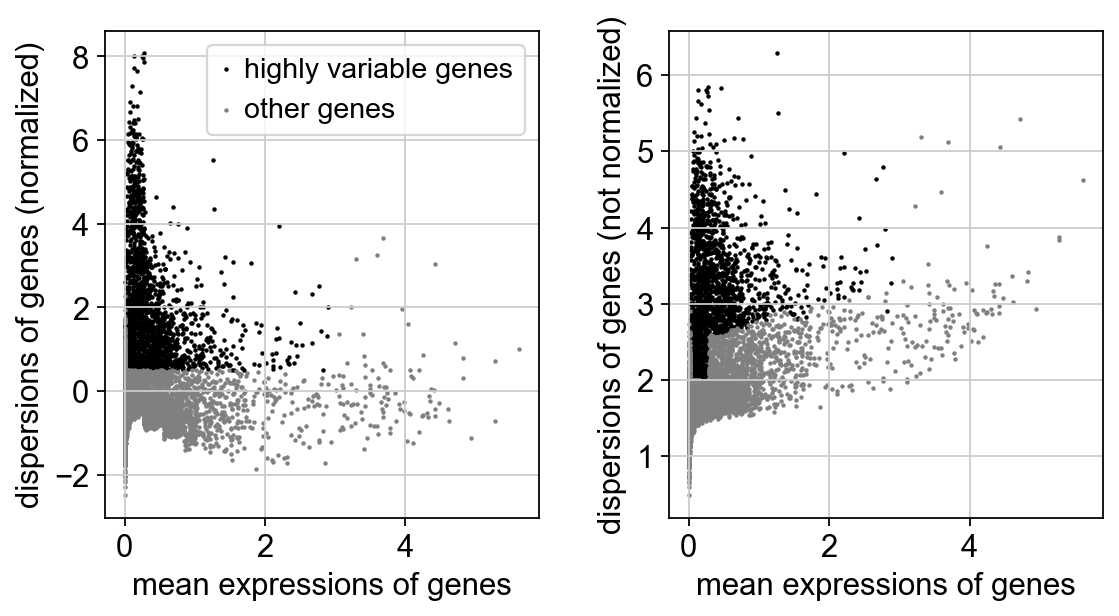

In [26]:
# Highly Variable Genes. The result is stored as an annotation in .var.highly_variable and auto-detected by PCA, neighbours.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Set the default .raw attribute of AnnData object to the normalized and logarithmized raw gene expression for later use
adata.raw = adata

# Filter to only keep the highly variable genes (unessecary step because PCA and etc recognize the .var.highly.variable annotation and do the filtering themselves)
# adata = adata[:, adata.var.highly_variable] --- if this is unecessary, I think this is the step affecting my CPDB norm layer

### Regress Out Features of non-interest

In [27]:
# Regress out total counts and mitochondrial features
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:12)


### Scale Data 

In [28]:
# Scale the data and put a max value of standard deviation to 10

sc.pp.scale(adata, max_value=10)

# Principal Component Analysis (PCA)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


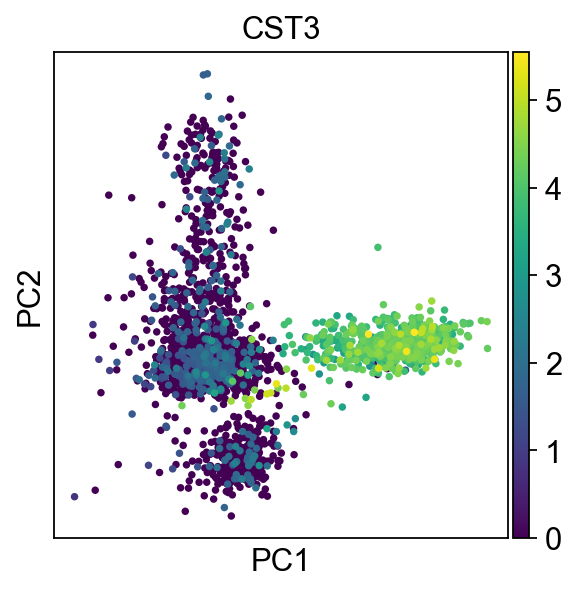

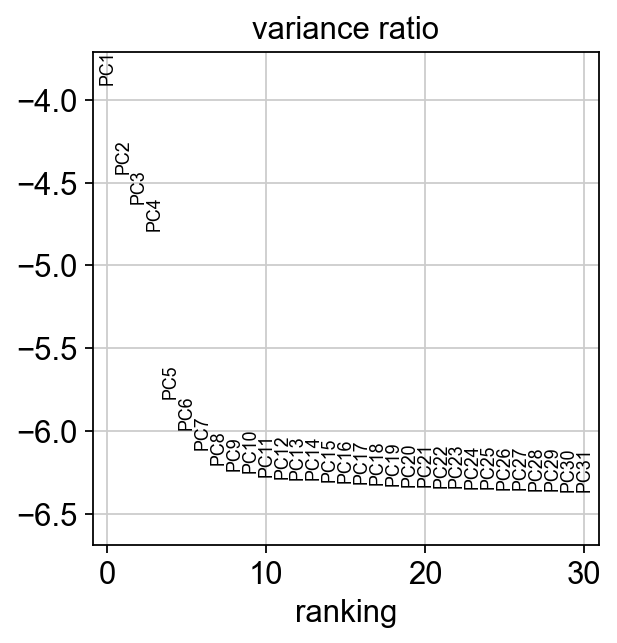

In [29]:
#Run PCA to find the most variables axes of the data and remove noise
sc.tl.pca(adata, svd_solver='arpack')

#Scatter plot
sc.pl.pca(adata, color='CST3')

#Make an elbow plot to determine how many PCs to use for clustering or tSNE
sc.pl.pca_variance_ratio(adata, log=True)

# Save Object

In [30]:
adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adata_preproc.h5ad')



# Neighborhood Graph

### Computing the Neighborhood graph and UMAP

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


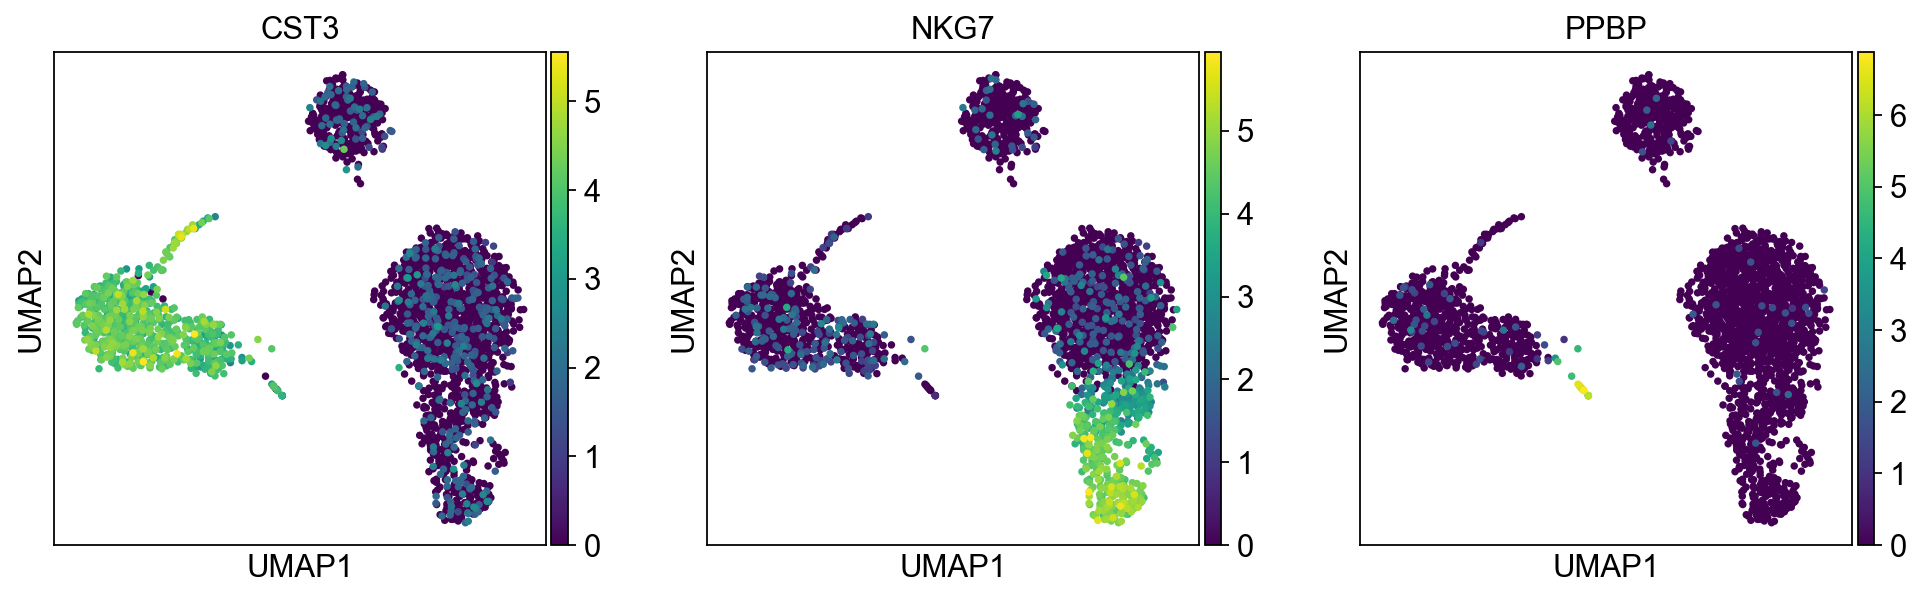

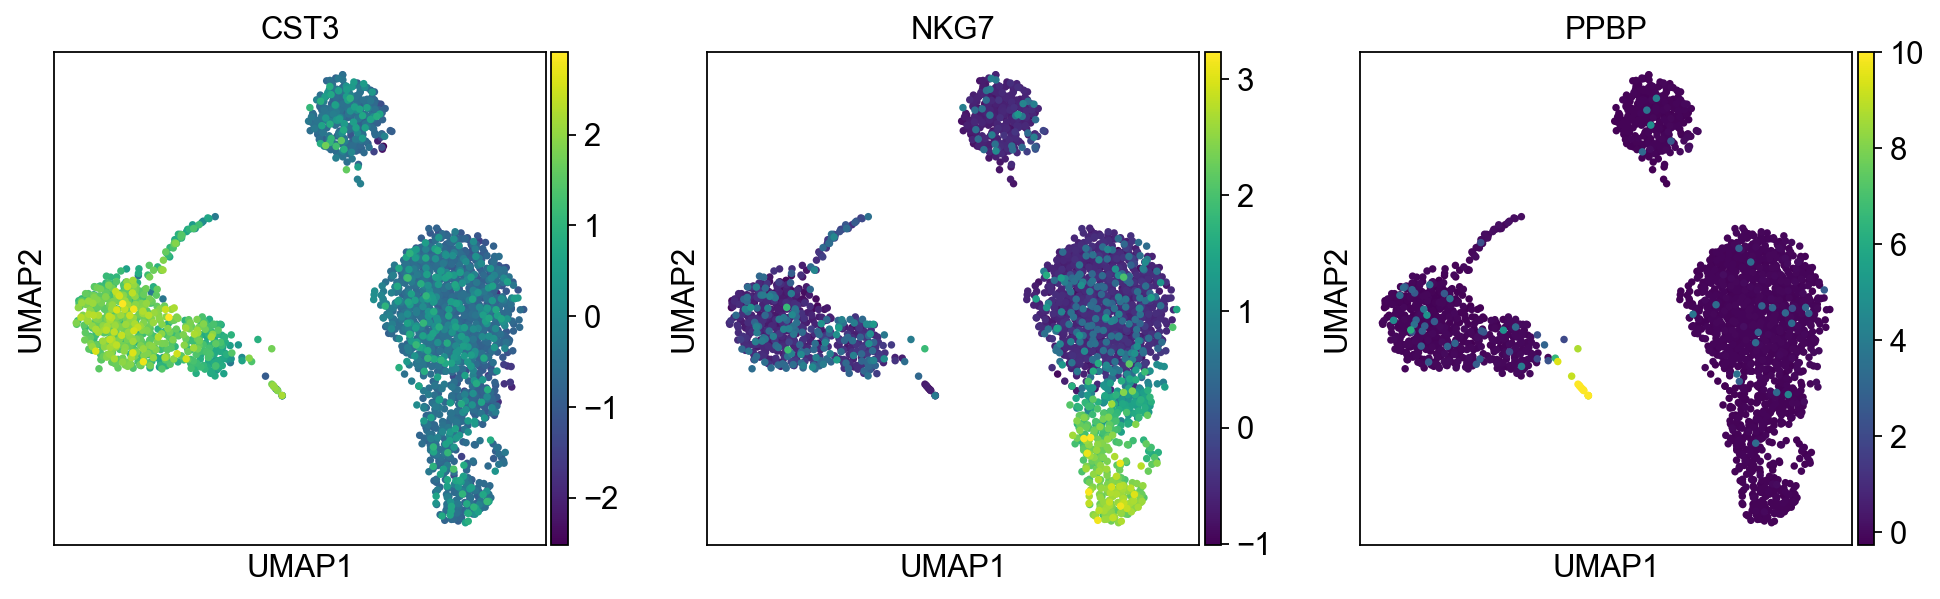

In [31]:
#Computing the neighbors grpah by setting the number of PCs (why 40?)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

#Embed data in UMAP (more faithful to the global connectivity than tSNE apparently)
sc.tl.umap(adata)

#Plot UMAP using the normalized/log data
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

#Plot UMAP using the normalized/log data/scaled/corrected for gene expression
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw = False)

### Clustering the neighborhood graph

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


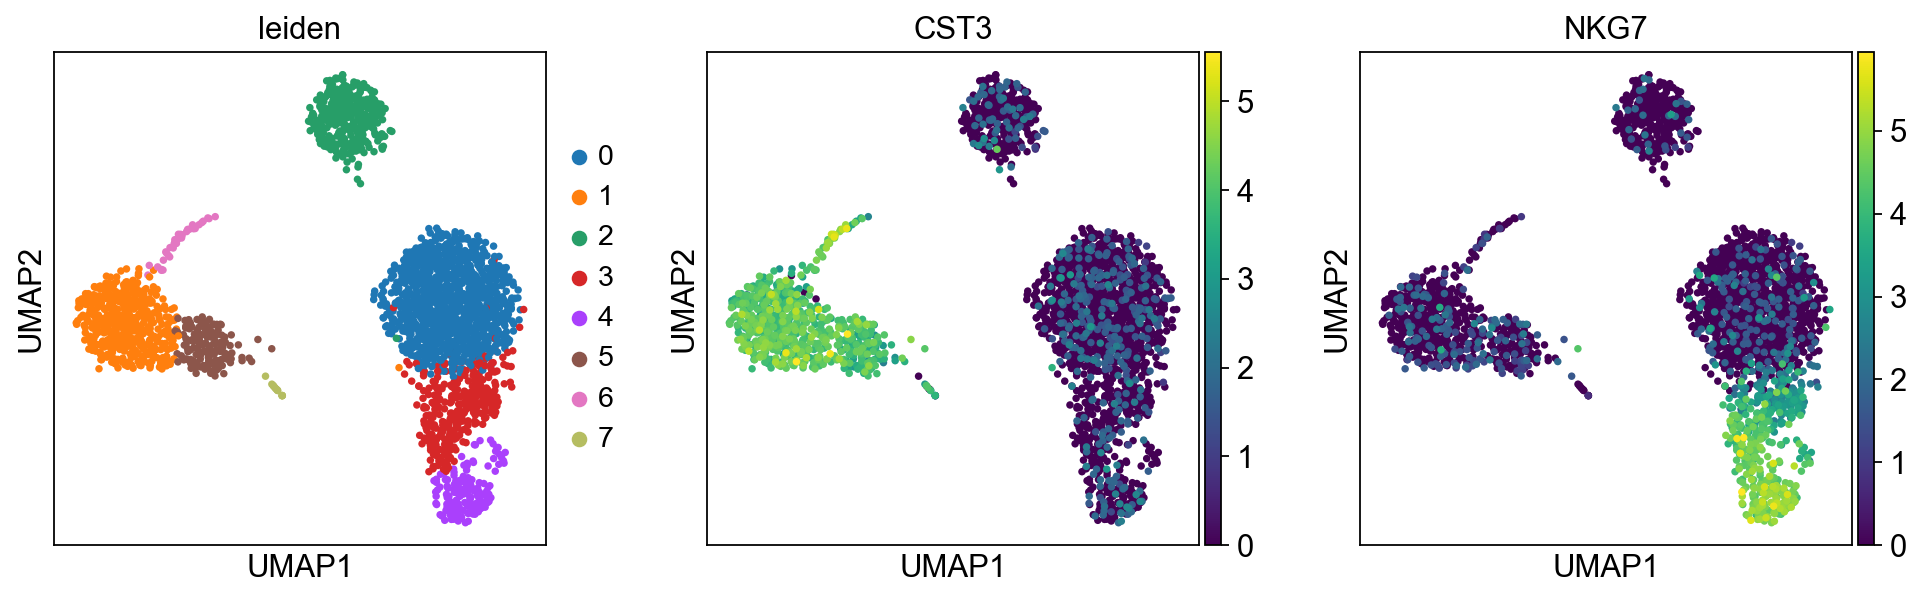

In [32]:
# Leiden graph-clustering method (community detection based on optimizing modularity). It uses the neighbors we previously calculated
sc.tl.leiden(adata)

# Plot the clusters
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


# Save Object

In [33]:
adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adata_clustered.h5ad')

adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm'
    obsp: 'distances', 'connectivities'

# Finding Marker Genes

### Finding marker genes using various methods (there are more powerful ways to do this, like DE)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


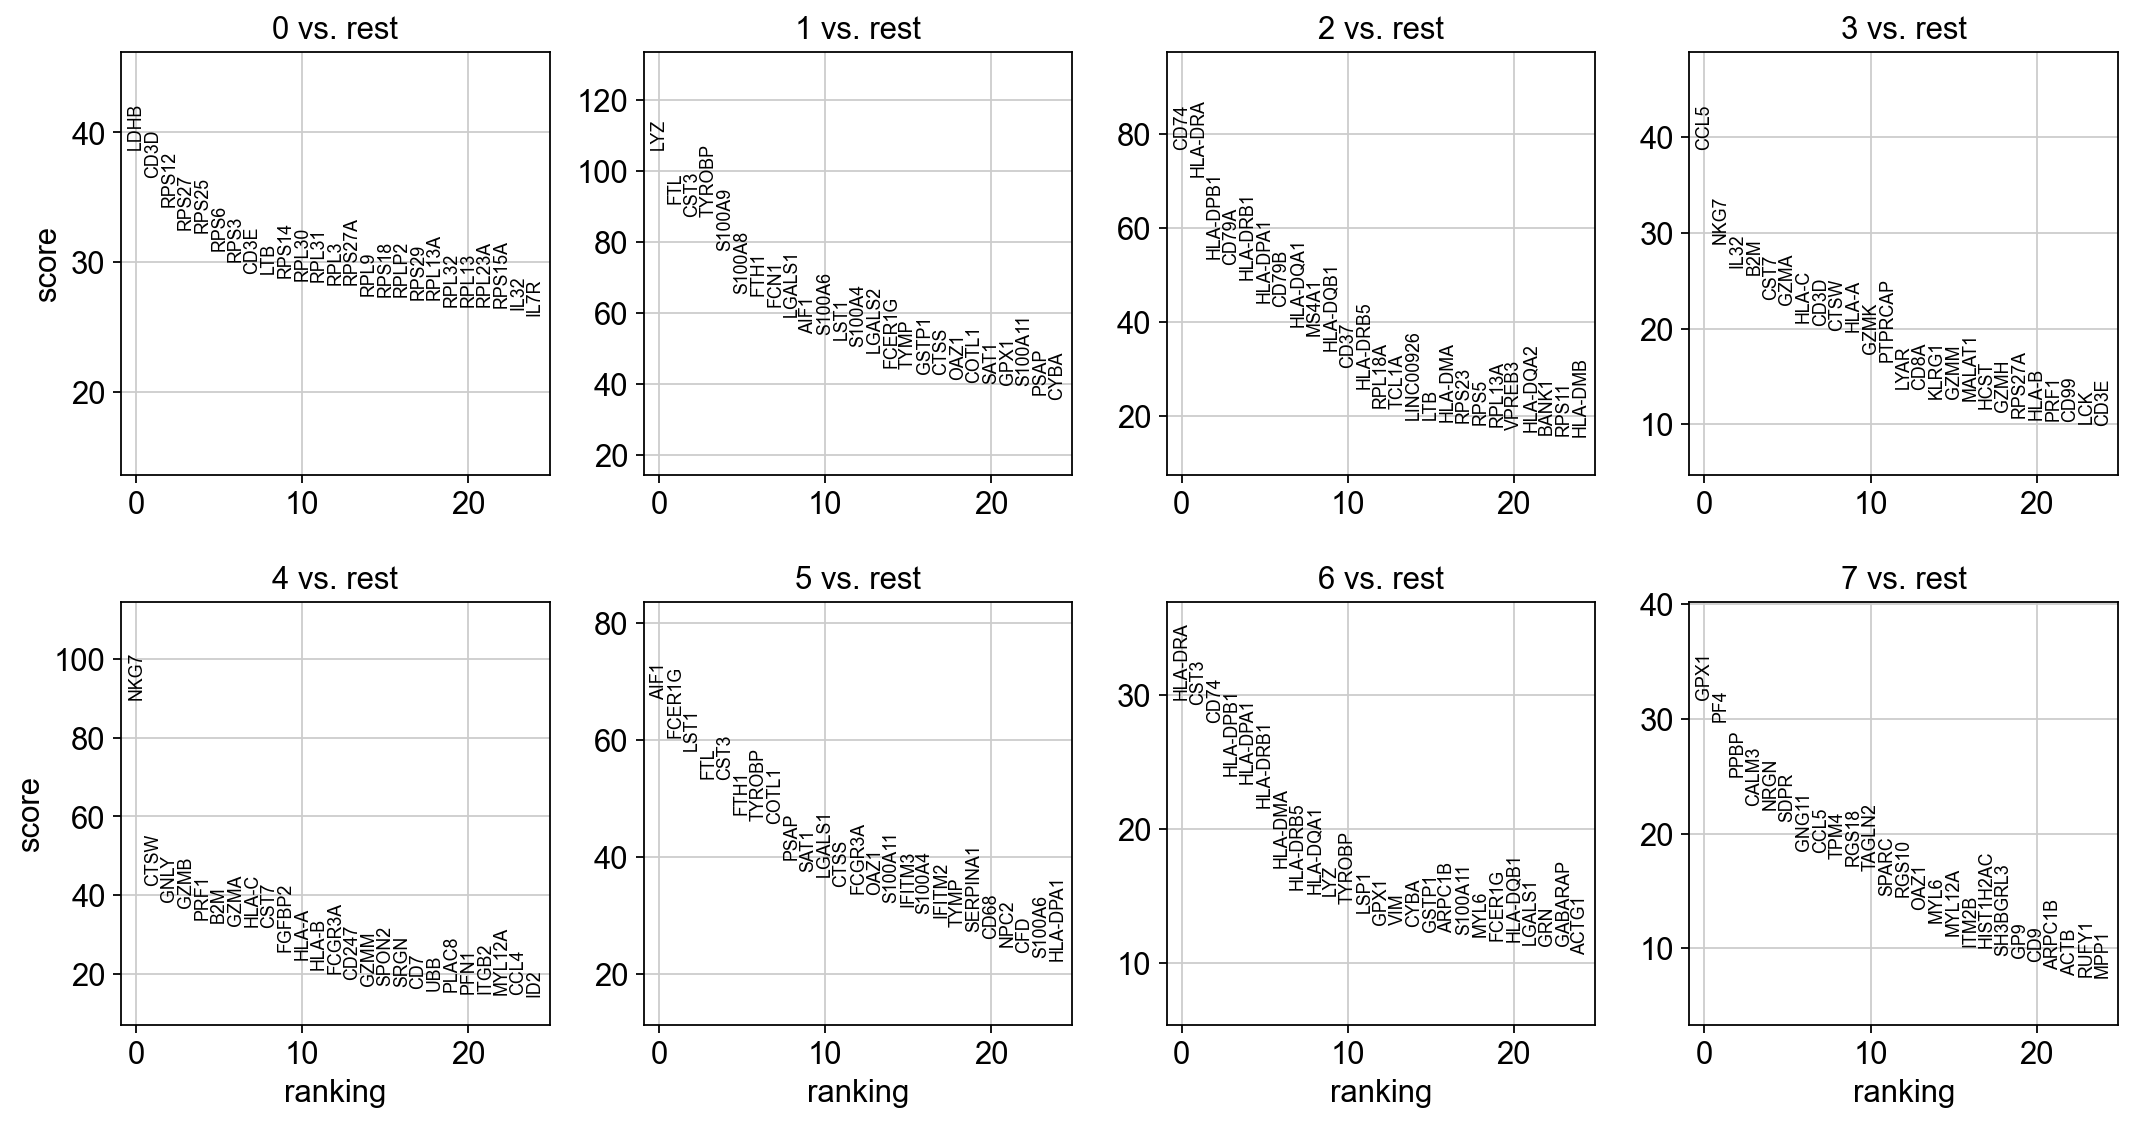

In [34]:
#Using the raw data and t-test.
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adata_MG_ttest.h5ad')

ranking genes
    finished (0:00:04)


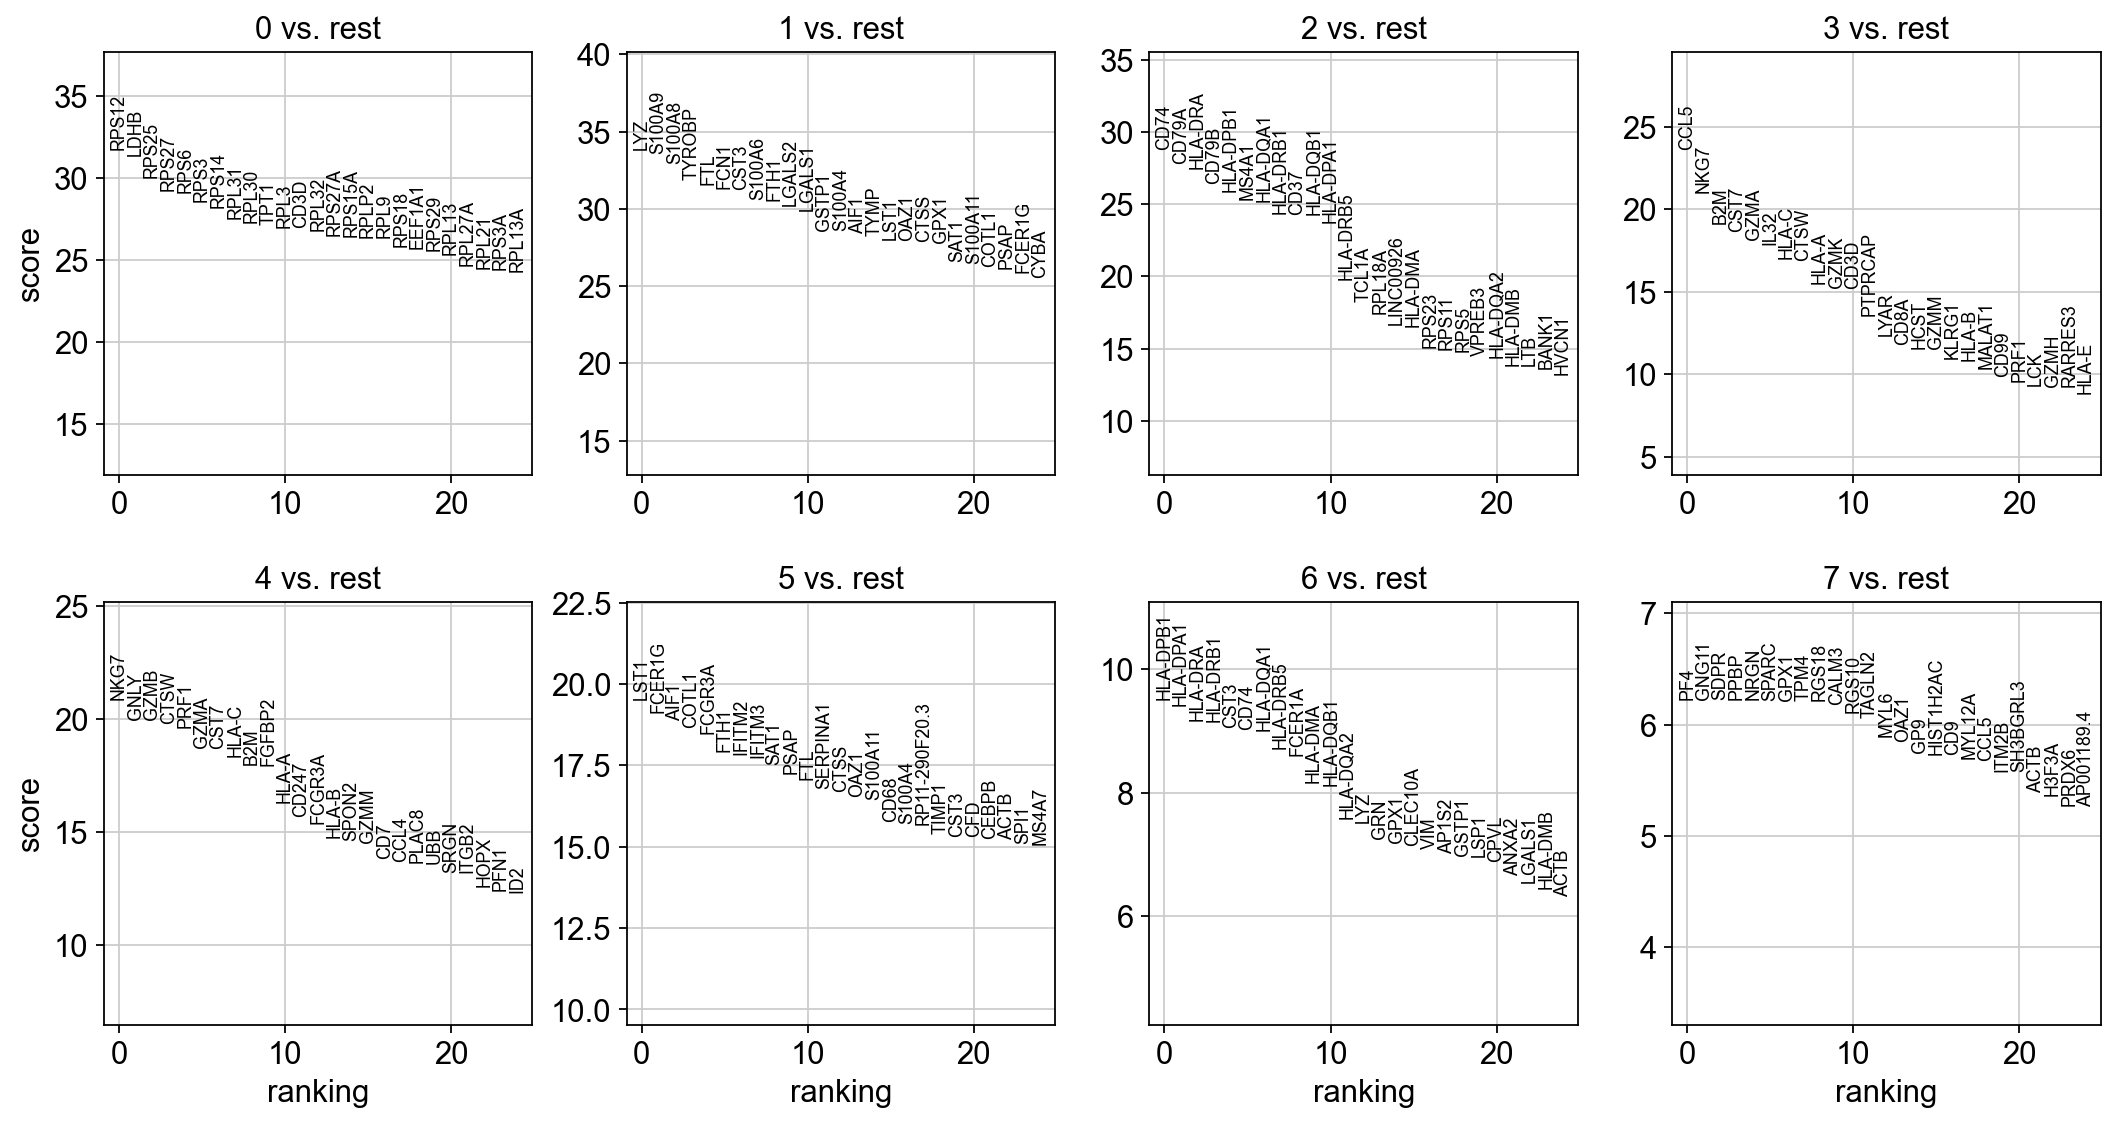

In [35]:
#Using the raw data and wilcoxon.
sc.settings.verbosity = 2
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adata_MG_wilcoxon.h5ad')

ranking genes
    finished (0:00:09)


/Users/jm52/miniconda3/envs/sc_qc_cluster_j/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


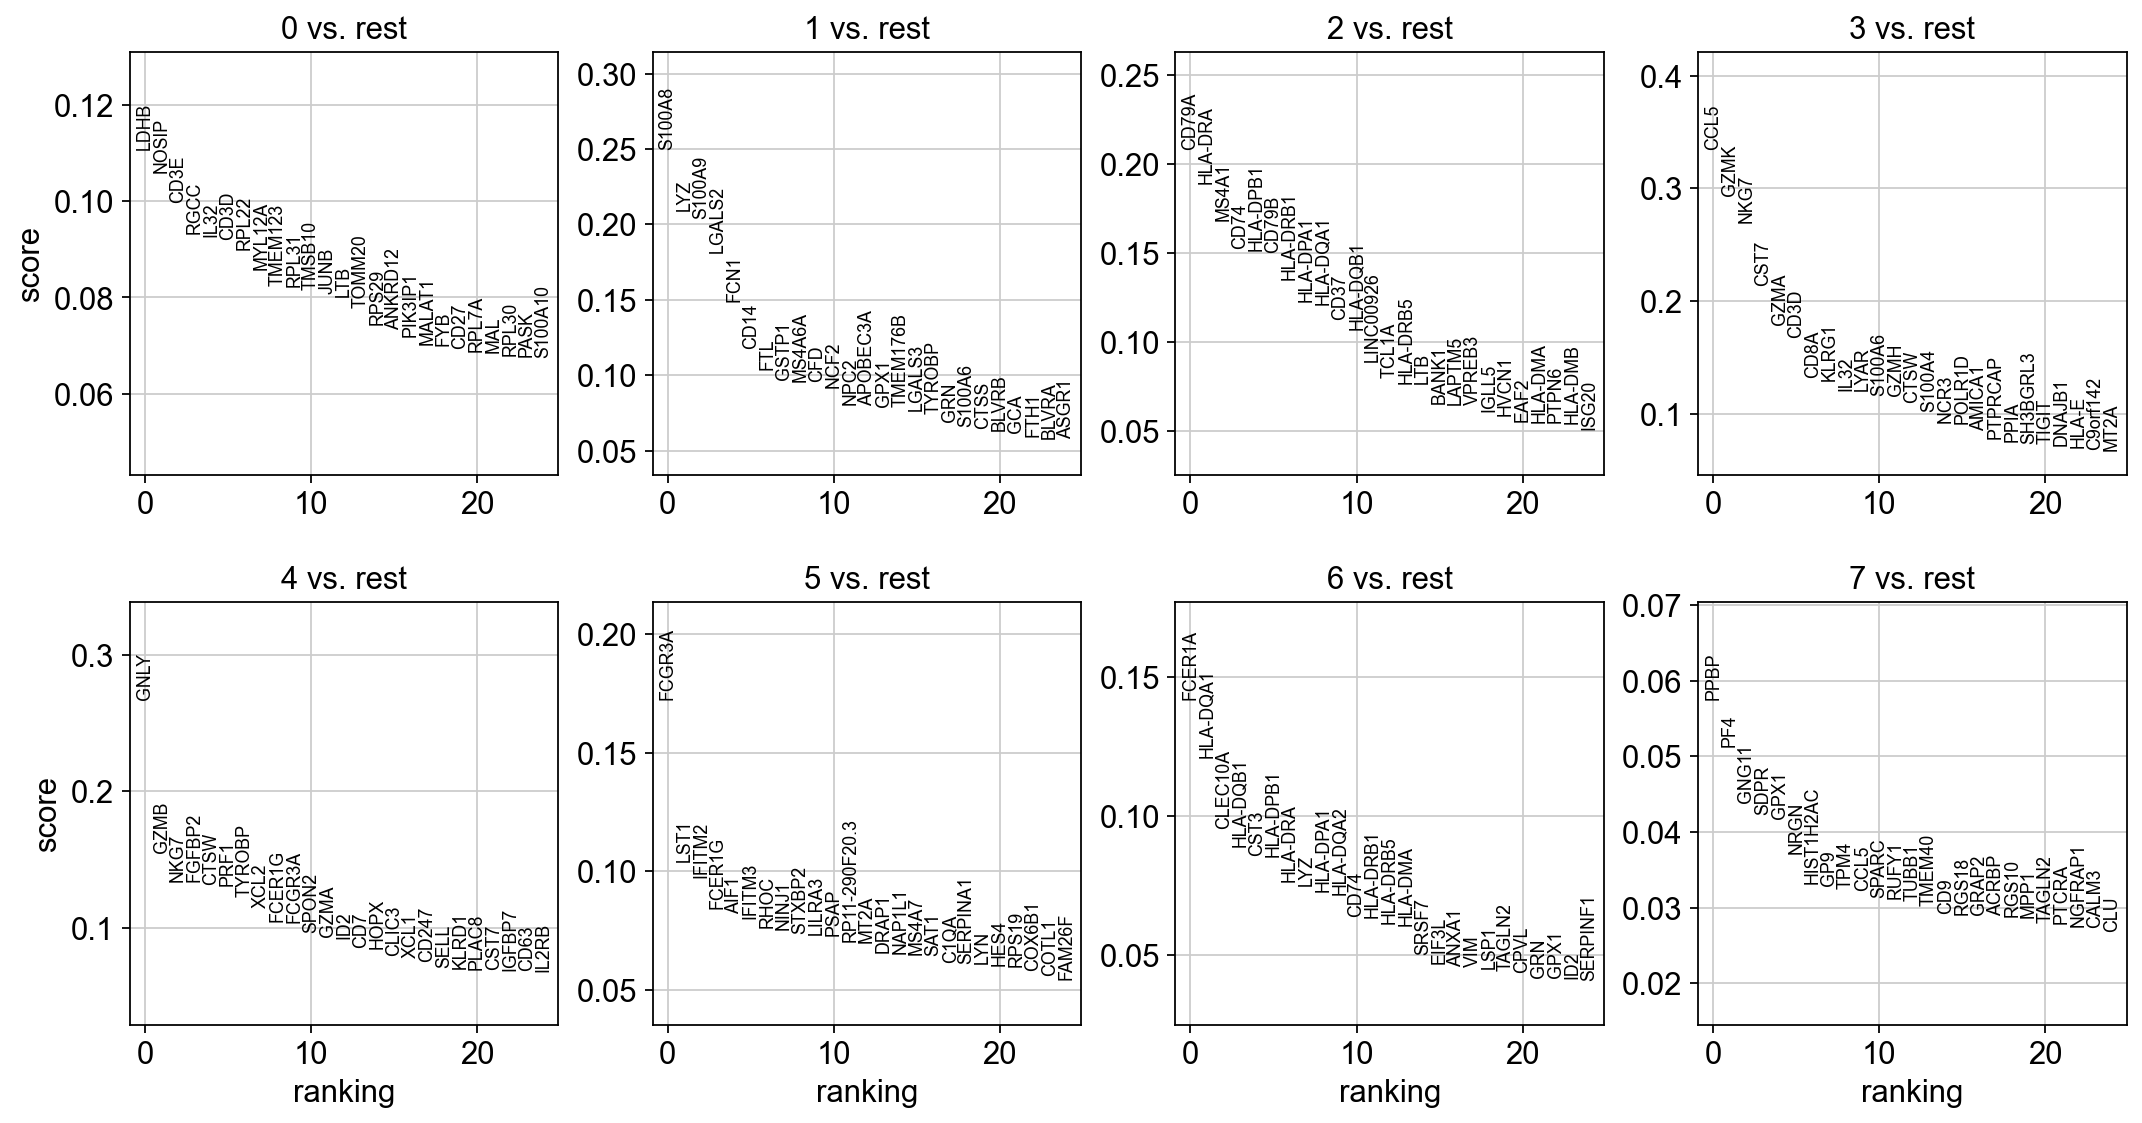

In [36]:
#Using the raw data and a logistic regression (uses a multi-variate component rather than univariate).
sc.settings.verbosity = 2
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adata_MG_logreg.h5ad')



### Marker Gene retrival

In [37]:
# Reload the file with the wilcoxon test
adata = sc.read('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adata_MG_wilcoxon.h5ad')

# Show the top 10 ranked genes per cluster (uns for unprocessed)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,NKG7,LST1,HLA-DPB1,PF4
1,LDHB,S100A9,CD79A,NKG7,GNLY,FCER1G,HLA-DPA1,GNG11
2,RPS25,S100A8,HLA-DRA,B2M,GZMB,AIF1,HLA-DRA,SDPR
3,RPS27,TYROBP,CD79B,CST7,CTSW,COTL1,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,PRF1,FCGR3A,CST3,NRGN


In [38]:
# Defining marker genes
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [39]:
# Get a table that shows the rank_genes_groups with the scores
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,6.788443e-221,LYZ,3.451023e-251,CD74,3.043536e-182,CCL5,1.602880e-123,NKG7,1.203971e-96,LST1,5.650219e-85,HLA-DPB1,1.807106e-21,PF4,4.722886e-10
1,LDHB,3.653629e-216,S100A9,1.594258e-247,CD79A,6.860832e-170,NKG7,3.444832e-98,GNLY,1.257170e-88,FCER1G,1.697236e-81,HLA-DPA1,4.442236e-21,GNG11,4.733899e-10
2,RPS25,1.145735e-197,S100A8,6.398145e-238,HLA-DRA,8.398068e-166,B2M,1.823976e-81,GZMB,1.429027e-88,AIF1,1.377723e-79,HLA-DRA,4.684930e-20,SDPR,4.733899e-10
3,RPS27,1.909099e-187,TYROBP,2.022021e-223,CD79B,1.171444e-153,CST7,8.145475e-78,CTSW,4.144726e-87,COTL1,9.684016e-78,HLA-DRB1,5.336773e-20,PPBP,4.744938e-10
4,RPS6,4.834384e-186,FTL,1.141645e-218,HLA-DPB1,6.167786e-148,GZMA,8.677498e-74,PRF1,1.692100e-85,FCGR3A,2.516161e-76,CST3,1.334148e-19,NRGN,4.800511e-10


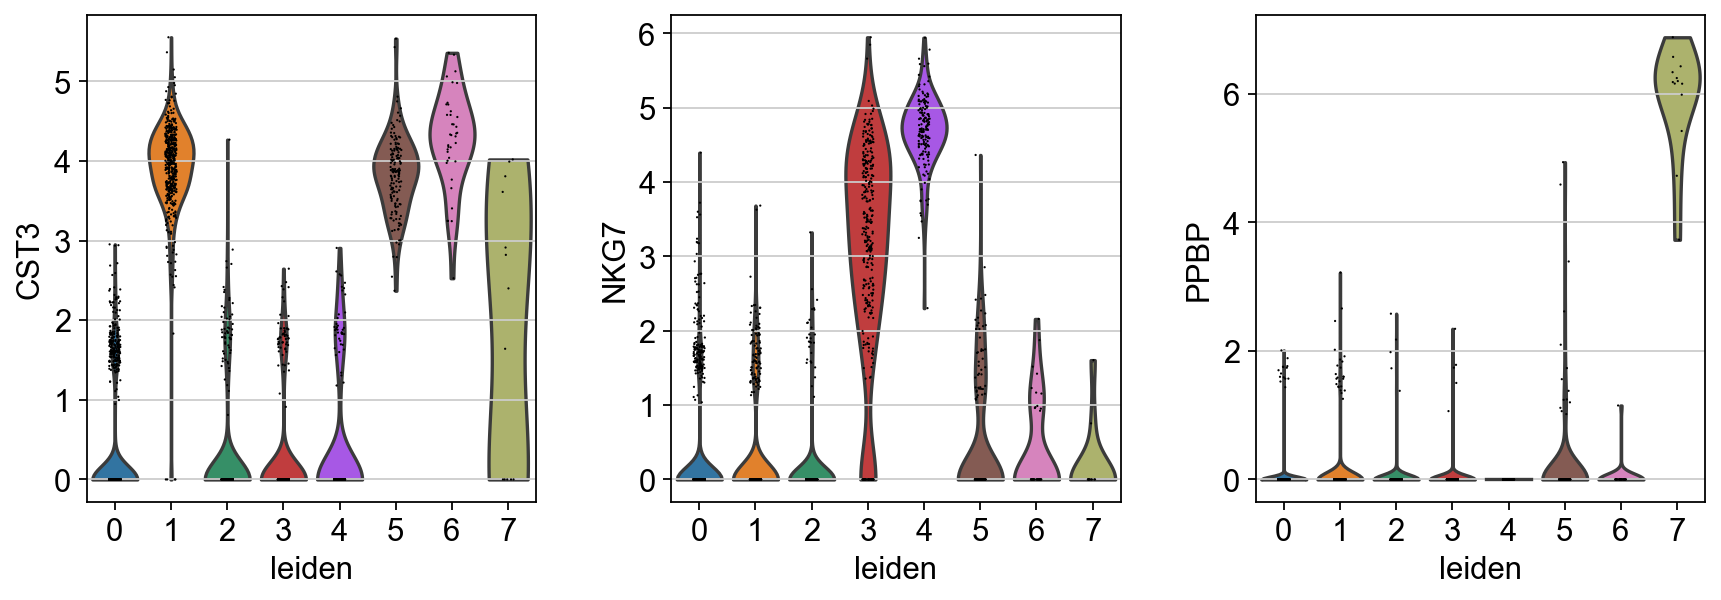

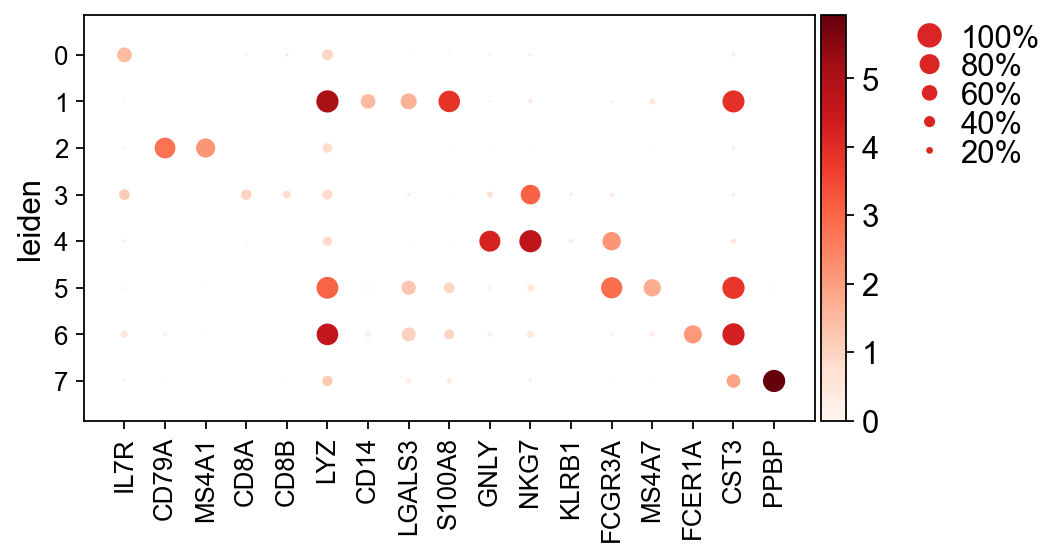

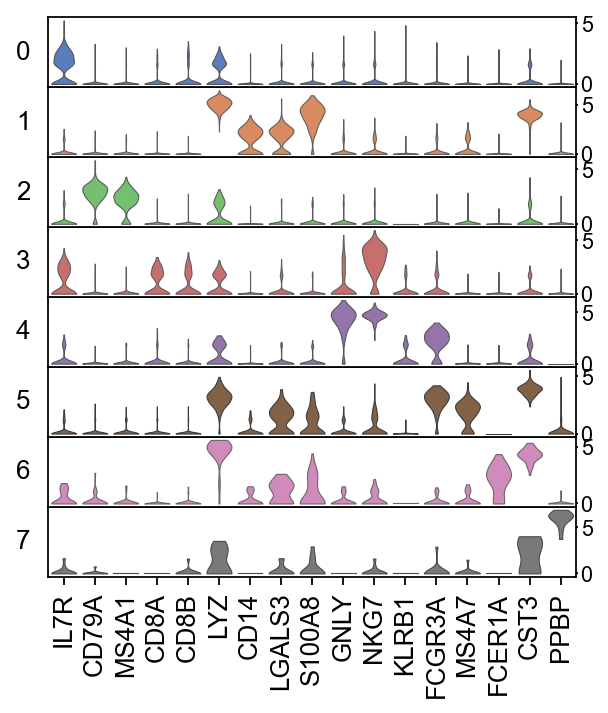

In [40]:
#Visualize gene expression per cluster
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')
sc.pl.dotplot(adata, marker_genes, groupby='leiden')
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


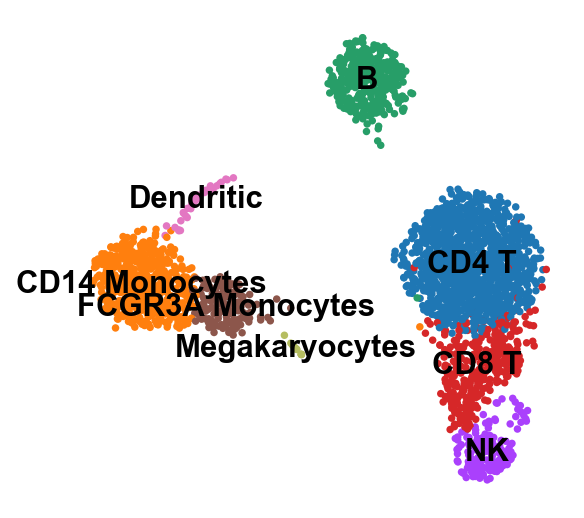

In [41]:
#Rename clusters
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

#Plot UMAP
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)


In [42]:
adata

#Saving the annotated data
adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adataannotated.h5ad')

#Saving the data using gzip 
adata.write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/adatazip.h5ad', compression='gzip') 

#Remove the dense and corrected matrices -- useful for sharing
adata.raw.to_adata().write('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/pbmc3k_withoutX.h5ad')


### CellPhoneDB Preperation

### Method 1 - As per Tutorial

#### Prepare Initial File (norm data, leiden identity)

In [43]:
#Reading the file that contains the normalized non-logged data previously saved
adatacpdb = sc.read('./adata_cpdb_norm_notlog.h5ad')

#Adding the leiden cluster ID as an additional observation annotation
adatacpdb.obs['cell_type'] = adata.obs.leiden

#Savefile
adatacpdb.write('./adata_cpdb_norm_notlog.h5ad')

#### Prepare cpdb_counts

In [44]:
#Transpose the adata object to have the cells as columns and genes as rows
df_exp_matrix = adatacpdb.T

#Convert the adata object to an arrayed dataframe
df_exp_matrix = pd.DataFrame(df_exp_matrix.X.toarray())

In [45]:
#Set columns IDs to cell name
df_exp_matrix.columns = adatacpdb.obs_names

In [46]:
#Set the row IDs (index) to gene names
df_exp_matrix.set_index(adatacpdb.var.index, inplace = True)

In [47]:
#Saving the file
df_exp_matrix.to_csv('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/cpdb_counts.txt',sep='\t')

In [48]:
df_exp_matrix.head()

,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,...,TTTCAGTGTCACGA-1,TTTCAGTGTCTATC-1,TTTCAGTGTGCAGT-1,TTTCCAGAGGTGAG-1,TTTCGAACACCTGA-1,TTTCGAACTCTCAT-1,TTTCTACTGAGGCA-1,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AP006222.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP11-206L10.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP11-206L10.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC00115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Prepare meta_counts

In [49]:
#Extract Cell ID and Leiden info from adatacpdb object into a Panda DF
df_meta = pd.DataFrame(data={'Cell':adatacpdb.obs_names, 'cell_type':list(adatacpdb.obs['cell_type'])})

#Reset the index so that it is the Cell ID
df_meta.set_index('Cell', inplace = True)

In [50]:
df_meta.to_csv('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/cpdb_meta.txt', sep='\t')

### Method 2 - Using Layers

#### Prepare cpdb_counts2

In [52]:
#Extract Numpy Array containing the Norm values
adatacpdb2 = adata.layers['norm']

adatacpdb2 = sp.sparse.csr_matrix.toarray(adatacpdb2)

#Transpose the Numpy array to have the Genes as Rows and cells as Columns
adatacpdb2 = adatacpdb2.T

#Convert the Array to a panda dataframe, while adding the columns and row names
adatacpdb2df = pd.DataFrame(data=adatacpdb2, index=adata.var_names, columns=adata.obs_names)

#adatacpdb2.to_csv('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/cpdb_counts2.txt',sep='\t')

#### Prepare cpdb_meta2

In [53]:
#Get the Cell ID and cell_type through leiden
df_meta2 = pd.DataFrame(data={'Cell':adata.obs_names, 'cell_type':list(adata.obs['leiden'])})

#Set the index to Cell
df_meta2.set_index('Cell', inplace = True)

df_meta2.to_csv('/Users/jm52/analysis/jm52_dummy/studies/3kpbmc_scanpy/cpdb_meta2.txt',sep='\t')


### Sanity Check

In [54]:
#Equivalence of the count matrices
print(adatacpdb2df.equals(df_exp_matrix))

#Equivalence of the meta matrices
print(df_meta2.equals(df_meta))

True
True
